# Análisis de modelo: CML, R², VIF

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/bin/python3 (found version "3.8.10") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/pablo-dallegri/Desktop/metnum_tp3/cml-y-modelado
-- Configuring done
-- Generating do

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python3 --version
import metnum

/home/pablo-dallegri/Desktop/metnum_tp3/cml-y-modelado/notebooks
Python 3.8.10


## Explorando los datos

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn.metrics as mtr
import matplotlib.pyplot as plt

df = pd.read_csv("../../dataset-tp3/expectativa_de_vida.csv")

In [4]:
df

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Poisoning,Status
0,0,Afghanistan,58.19375,269.0625,78.2500,0.014375,34.960110,64.562500,2362.2500,15.51875,...,52.312500,0.10000,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250,1.07,Developing
1,1,Albania,75.15625,45.0625,0.6875,4.848750,193.259091,98.000000,53.3750,49.06875,...,98.062500,0.10000,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750,0.33,Developing
2,2,Algeria,73.61875,108.1875,20.3125,0.406667,236.185241,78.000000,1943.8750,48.74375,...,91.875000,0.10000,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250,0.74,Developing
3,3,Angola,49.01875,328.5625,83.7500,5.740667,102.100268,70.222222,3561.3125,18.01875,...,47.687500,2.36875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375,2.41,Developing
4,4,Antigua and Barbuda,75.05625,127.5000,0.0000,7.949333,1001.585226,98.266667,0.0000,38.42500,...,98.312500,0.12500,9759.305728,NaN,3.42500,3.37500,0.488625,8.84375,0.56,Developing
5,5,Argentina,75.15625,106.0000,10.1250,7.966667,773.038981,81.285714,2.0000,54.98125,...,92.375000,0.10000,6998.575103,2.012120e+07,1.07500,0.95000,0.794125,16.50625,0.54,Developing
6,6,Armenia,73.40000,117.3750,1.0000,3.702667,131.007419,87.562500,274.2500,44.70625,...,87.375000,0.10000,1999.986318,1.015165e+06,2.03750,2.11250,0.698375,11.78750,0.90,Developing
7,7,Australia,81.81250,63.1875,1.0000,10.155333,5332.226473,93.400000,103.9375,55.86250,...,86.875000,0.10000,34637.565047,4.587010e+06,0.66875,0.62500,0.918125,20.03750,0.15,Developed
8,8,Austria,81.48125,65.7500,0.0000,12.236000,4928.439188,81.062500,77.2500,48.28750,...,86.750000,0.10000,33827.476309,6.474880e+06,1.73125,1.93750,0.862375,15.38750,0.11,Developed
9,9,Azerbaijan,70.73125,115.1875,6.0625,0.992000,131.148747,59.214286,598.1875,43.84375,...,82.312500,0.10000,3302.947807,2.157370e+06,2.90000,2.94375,0.702688,11.35000,0.92,Developing


# Análisis

In [55]:
def analisis_VIF(datos, etiquetas) :
    print ("VIF:")
    for etiqueta in etiquetas :
        demas_etiquetas = etiquetas.copy()
        demas_etiquetas.remove(etiqueta)
        r2_sin_ajuste = analisis(datos, demas_etiquetas, etiqueta, "VIF")
        vif = 1/(1-r2_sin_ajuste)
        print('\t', "%+.6f" % vif, '\t', etiqueta)
    print()
    
def analisis_cook(datos, etiquetas, resultados, predicciones, residuos) :
    print ("COOK:")
    s2 = np.mean(residuos**2)
    p = len(etiquetas)+1  # Cantidad de predictores (creo)
    
    cook_is = []

    for i in range(datos.shape[0]) :
        mascara = np.full(datos.shape[0], True)
        mascara[i] = False
        
        datos_truncados = datos[mascara]
        predicciones_del_modelo_truncado = analisis(datos_truncados, etiquetas, resultados, "cook")
        
        predicciones_del_modelo_completo = predicciones[mascara]
        
        numerador = np.sum((predicciones_del_modelo_completo-predicciones_del_modelo_truncado)**2)
        cook_i = numerador/(p*s2)
        cook_is.append(cook_i)
    

    for i in range(len(cook_is)) :
        if (cook_is[i] > np.mean([max(cook_is), min(cook_is)])) :
            print('\t', "%+.6f" % cook_is[i], '\t', datos["Country"][datos.index[i]])


    
    plt.plot(range(len(cook_is)), cook_is, 'x')
    plt.xlabel("# País")
    plt.ylabel("Distancia de Cook")
    plt.hlines(0, xmin=min(cook_is), xmax=max(cook_is))
    plt.title("Cook")
    plt.show()
    
    print()
        

In [6]:
def analisis(datos, etiquetas, resultados, modo="completo") :
    expectativas = datos[resultados].values.reshape(-1, 1)
    
    # Elegir los predictores a usar de entre los datos
    predictores = datos[etiquetas].values
    cantidad_predictores = predictores.shape[1]
    
    # Verificar que cada muestra de predictores tiene un resultado asociado
    cantidad_muestras = predictores.shape[0]
    assert(cantidad_muestras == expectativas.shape[0])
    if (modo == "completo") :
        print("Países:", cantidad_muestras)
        print()
    
    # Agregar columna de 1's para el coeficiente constante
    predictores_con_constante = np.append(predictores.copy(), np.ones((cantidad_muestras,1)), axis=1)
    
    # Calcular coeficientes óptimos según Cuadrados Mínimos Lineales (C++)
    coeficientes = metnum.CML().solve(predictores_con_constante, expectativas)
        
    if (modo == "completo") :
        print("COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):")
        print('\t',"Constante:",coeficientes[cantidad_predictores])
        for i in range(cantidad_predictores) :
            print('\t', "%+.6f" % coeficientes[i], '\t', etiquetas[i])
        print()
        
    
    # Calcular las predicciones y residuos
    predicciones = np.zeros(cantidad_muestras)
    residuos = np.zeros(cantidad_muestras)
    for i in range(cantidad_muestras) :
        predicciones[i] = np.dot(predictores_con_constante[i], coeficientes)
        residuos[i] = predicciones[i] - expectativas[i]
    
    if (modo == "cook") : return predicciones
    
    # Calcular R² y R² ajustado
    r2_sin_ajuste = mtr.r2_score(expectativas, predicciones)
    r2_con_ajuste = 1-(1-r2_sin_ajuste)*(cantidad_muestras-1)/(cantidad_muestras-cantidad_predictores-1)
    if (modo == "VIF") : return r2_sin_ajuste
    print("VARIABILIDAD EXPLICADA")
    print('\t',"R² sin ajuste:",r2_sin_ajuste)
    print('\t',"R² con ajuste:",r2_con_ajuste)
    print()
    
    
    # Calcular las muestras estandarizadas según cada predictor
    predictores_estandarizados = predictores.copy()
    for i in range(cantidad_predictores) :
        # Restar media
        predictores_estandarizados[:,i] -= np.mean(predictores_estandarizados[:,i])
        # Dividir por desvío estandar, en caso de no ser nulo
        if (np.std(predictores_estandarizados[:,i]) != 0) :
            predictores_estandarizados[:,i] /= np.std(predictores_estandarizados[:,i])
    
    # Calcular la significancia relativa entre coeficientes
    coeficientes_relativos = metnum.CML().solve(predictores_estandarizados, expectativas)
    print("COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):")
    for i in range(cantidad_predictores) :
        print('\t', "%+.6f" % coeficientes_relativos[i], '\t', etiquetas[i])
    print()
    
    analisis_VIF(datos, etiquetas)
    analisis_cook(datos, etiquetas, resultados, predicciones, residuos)
    
    # Gráfico "residuo vs predicción" (normalizado)
    residuos_estandarizados = residuos.copy()/np.std(residuos)
    for i in range(cantidad_muestras) :
        # Restar media
        residuos_estandarizados[i] -= np.mean(residuos)
        # Dividir por desvío estandar
        residuos_estandarizados[i] /= np.std(residuos)
    plt.plot(predicciones, residuos_estandarizados, 'x')
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos estandarizados")
    plt.hlines(0, xmin=min(predicciones), xmax=max(predicciones))
    plt.title("Residual plot")
    plt.show()
    
    print("--------------------------------------------------------------------------------------------------------------------------------")


# Sanitización de dataset

In [7]:
def completar_medias(originales) :
    completados = df.copy()[:]
    for columna in completados.columns :
        if (columna == "Country" or columna == "Status") : continue
        media = np.nanmean(completados[columna])
        es_NaN = completados[columna].isnull()
        completados[columna][es_NaN] = media
    return completados


def completar_medianas(originales) :
    completados = df.copy()[:]
    for columna in completados.columns :
        if (columna == "Country" or columna == "Status") : continue
        mediana = np.nanmedian(completados[columna])
        es_NaN = completados[columna].isnull()
        completados[columna][es_NaN] = mediana
    return completados


def completar_medianas_segregado(originales) :
    completados = df.copy()[:]
    for columna in completados.columns :
        if (columna != "Country" and columna != "Status") :
            mediana_desarrollados = np.nanmedian(df[df["Status"] == "Developed"][columna])
            mediana_en_desarrollo = np.nanmedian(df[df["Status"] == "Developing"][columna])

            es_NaN_desarrollados = df[columna].isnull() * df["Status"] == "Developed"
            es_NaN_en_desarrollo = df[columna].isnull() * df["Status"] == "Developing"
            
            nueva_columna = completados[columna].copy()
            nueva_columna[es_NaN_en_desarrollo] = mediana_en_desarrollo
            nueva_columna[es_NaN_desarrollados] = mediana_desarrollados
            completados[columna] = nueva_columna
        
    return completados
            
            
datos_con_medias = completar_medias(df)
datos_con_medianas = completar_medianas(df)
datos_con_medianas_segregadas = completar_medianas_segregado(df)

In [8]:
# Estaban así
df[df["Schooling"].isnull()][["Country", "Schooling", "Status"]]

,Country,Schooling,Status
42,Czechia,NaN,Developed
43,Côte d'Ivoire,NaN,Developing
44,Democratic People's Republic of Korea,NaN,Developing
45,Democratic Republic of the Congo,NaN,Developing
130,Republic of Korea,NaN,Developing
131,Republic of Moldova,NaN,Developing
148,Somalia,NaN,Developing
172,United Kingdom of Great Britain and Northern I...,NaN,Developed
173,United Republic of Tanzania,NaN,Developing
174,United States of America,NaN,Developed


In [9]:
# Aber si funcó
datos_con_medianas_segregadas[df["Schooling"].isnull()][["Country", "Schooling", "Status"]]

,Country,Schooling,Status
42,Czechia,15.86875,Developed
43,Côte d'Ivoire,11.66875,Developing
44,Democratic People's Republic of Korea,11.66875,Developing
45,Democratic Republic of the Congo,11.66875,Developing
130,Republic of Korea,11.66875,Developing
131,Republic of Moldova,11.66875,Developing
148,Somalia,11.66875,Developing
172,United Kingdom of Great Britain and Northern I...,15.86875,Developed
173,United Republic of Tanzania,11.66875,Developing
174,United States of America,15.86875,Developed


# Eleción de dataset

### Todos los predictores originales

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [60.25426324]
	 -0.048628 	 Adult Mortality
	 +0.043044 	 infant deaths
	 +0.142369 	 Alcohol
	 +0.000433 	 percentage expenditure
	 -0.025745 	 Hepatitis B
	 +0.000015 	 Measles
	 +0.047318 	 BMI
	 -0.038760 	 under-five deaths
	 +0.000012 	 Polio
	 +0.057678 	 Total expenditure
	 +0.106973 	 Diphtheria
	 -0.166200 	 HIV/AIDS
	 -0.000014 	 GDP
	 +0.000000 	 Population
	 -0.114950 	 thinness  1-19 years
	 +0.154548 	 thinness 5-9 years
	 +5.890270 	 Income composition of resources
	 +0.317813 	 Schooling
	 -0.141787 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9337306447840312
	 R² con ajuste: 0.9260059960165257

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -4.664516 	 Adult Mortality
	 +4.979244 	 infant deaths
	 +0.544894 	 Alcohol
	 +0.638817 	 percentage expenditure
	 -0.436336 	 Hepatitis B
	 +0.121803 	 Measles
	 +0.746659 	 BMI
	 -6.085169 	 under-five deaths
	 +

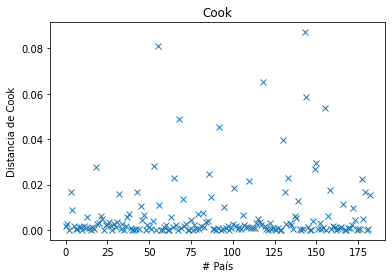

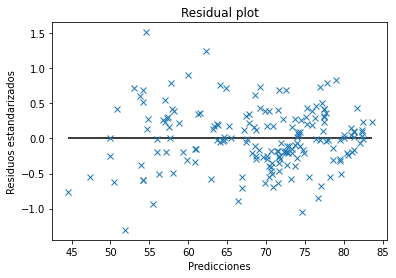

--------------------------------------------------------------------------------------------------------------------------------
Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [60.12666624]
	 -0.048783 	 Adult Mortality
	 +0.043184 	 infant deaths
	 +0.134354 	 Alcohol
	 +0.000582 	 percentage expenditure
	 -0.024702 	 Hepatitis B
	 +0.000011 	 Measles
	 +0.050372 	 BMI
	 -0.038283 	 under-five deaths
	 -0.000947 	 Polio
	 +0.033471 	 Total expenditure
	 +0.108573 	 Diphtheria
	 -0.162761 	 HIV/AIDS
	 -0.000037 	 GDP
	 +0.000000 	 Population
	 -0.120914 	 thinness  1-19 years
	 +0.161945 	 thinness 5-9 years
	 +6.045710 	 Income composition of resources
	 +0.320824 	 Schooling
	 -0.136932 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9339016609827527
	 R² con ajuste: 0.9261969466187792

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -4.679372 	 Adult Mortality
	 +4.995447 	 infant deaths
	 +0.514303 	 Alcohol
	 +0.8588

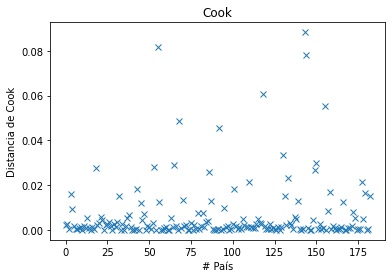

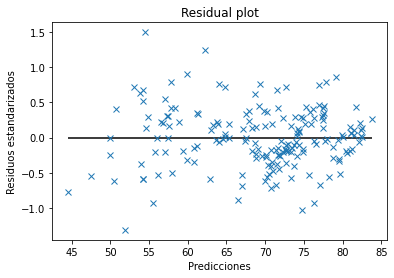

--------------------------------------------------------------------------------------------------------------------------------
Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [59.87268556]
	 -0.047892 	 Adult Mortality
	 +0.042320 	 infant deaths
	 +0.119733 	 Alcohol
	 +0.000737 	 percentage expenditure
	 -0.023451 	 Hepatitis B
	 +0.000011 	 Measles
	 +0.048531 	 BMI
	 -0.037533 	 under-five deaths
	 +0.005171 	 Polio
	 +0.002655 	 Total expenditure
	 +0.101914 	 Diphtheria
	 -0.170770 	 HIV/AIDS
	 -0.000057 	 GDP
	 +0.000000 	 Population
	 -0.101756 	 thinness  1-19 years
	 +0.140496 	 thinness 5-9 years
	 +6.404333 	 Income composition of resources
	 +0.337102 	 Schooling
	 -0.136990 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9340652302171603
	 R² con ajuste: 0.9263795822056636

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -4.593906 	 Adult Mortality
	 +4.895473 	 infant deaths
	 +0.458576 	 Alcohol
	 +1.0888

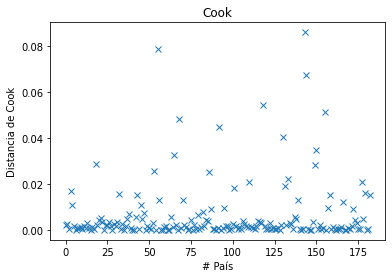

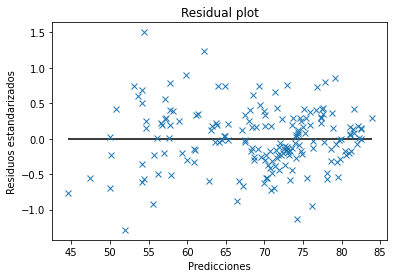

--------------------------------------------------------------------------------------------------------------------------------


In [10]:
analisis(datos_con_medias, ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')
analisis(datos_con_medianas, ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

### Un predictor de cada grupo correlacionado

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [63.85388772]
	 -0.054612 	 Adult Mortality
	 -0.001964 	 infant deaths
	 +0.162630 	 Alcohol
	 +0.044843 	 Hepatitis B
	 +0.052607 	 BMI
	 +0.045639 	 Total expenditure
	 -0.114284 	 HIV/AIDS
	 +0.000069 	 GDP
	 +0.664545 	 Schooling
	 -0.334862 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9114165265922249
	 R² con ajuste: 0.9062663246499124

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -5.238453 	 Adult Mortality
	 -0.227243 	 infant deaths
	 +0.622437 	 Alcohol
	 +0.760034 	 Hepatitis B
	 +0.830132 	 BMI
	 +0.087037 	 Total expenditure
	 -0.506902 	 HIV/AIDS
	 +0.688129 	 GDP
	 +2.015768 	 Schooling
	 -0.424252 	 Poisoning

VIF:
	 +3.730487 	 Adult Mortality
	 +1.195219 	 infant deaths
	 +1.764329 	 Alcohol
	 +1.299265 	 Hepatitis B
	 +2.373227 	 BMI
	 +1.357220 	 Total expenditure
	 +2.188838 	 HIV/AIDS
	 +1.776003 	 GDP
	 +2.930234 	 Schooling
	 +1.198530 	 Poisoni

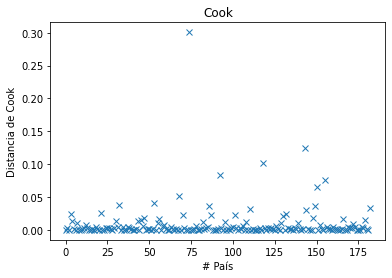

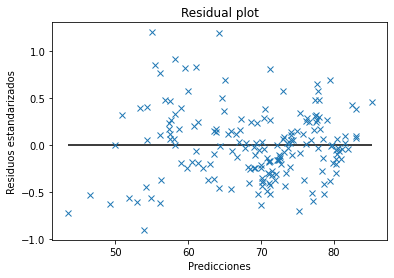

--------------------------------------------------------------------------------------------------------------------------------
Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [63.80451043]
	 -0.054516 	 Adult Mortality
	 -0.001945 	 infant deaths
	 +0.161222 	 Alcohol
	 +0.045641 	 Hepatitis B
	 +0.054637 	 BMI
	 +0.042097 	 Total expenditure
	 -0.115200 	 HIV/AIDS
	 +0.000065 	 GDP
	 +0.662162 	 Schooling
	 -0.339324 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9112200978546499
	 R² con ajuste: 0.906058475636897

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -5.229270 	 Adult Mortality
	 -0.224995 	 infant deaths
	 +0.617151 	 Alcohol
	 +0.774482 	 Hepatitis B
	 +0.862645 	 BMI
	 +0.080284 	 Total expenditure
	 -0.510967 	 HIV/AIDS
	 +0.658336 	 GDP
	 +2.009162 	 Schooling
	 -0.429905 	 Poisoning

VIF:
	 +3.764103 	 Adult Mortality
	 +1.195657 	 infant deaths
	 +1.772690 	 Alcohol
	 +1.315991 	 Hepatitis B
	 +2.301

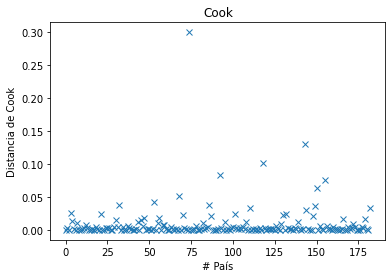

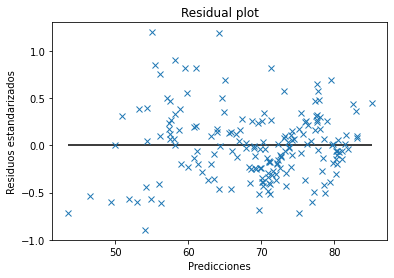

--------------------------------------------------------------------------------------------------------------------------------
Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [63.86498349]
	 -0.053729 	 Adult Mortality
	 -0.002134 	 infant deaths
	 +0.137427 	 Alcohol
	 +0.043531 	 Hepatitis B
	 +0.052459 	 BMI
	 -0.025470 	 Total expenditure
	 -0.122311 	 HIV/AIDS
	 +0.000058 	 GDP
	 +0.708222 	 Schooling
	 -0.314903 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9102263281840931
	 R² con ajuste: 0.9050069286599125

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -5.153779 	 Adult Mortality
	 -0.246834 	 infant deaths
	 +0.526346 	 Alcohol
	 +0.747425 	 Hepatitis B
	 +0.827791 	 BMI
	 -0.048578 	 Total expenditure
	 -0.542504 	 HIV/AIDS
	 +0.597551 	 GDP
	 +2.176901 	 Schooling
	 -0.398965 	 Poisoning

VIF:
	 +3.885614 	 Adult Mortality
	 +1.193811 	 infant deaths
	 +1.877972 	 Alcohol
	 +1.339828 	 Hepatitis B
	 +2.39

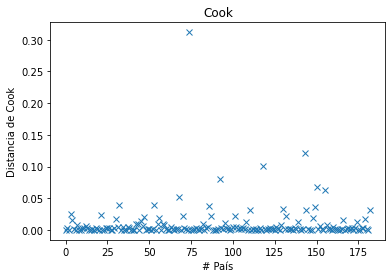

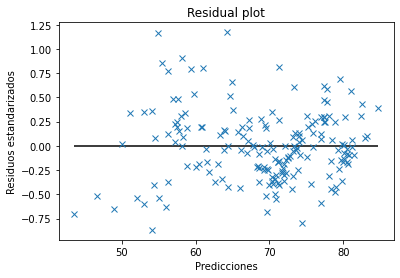

--------------------------------------------------------------------------------------------------------------------------------


In [11]:
analisis(datos_con_medias, ['Adult Mortality', 'infant deaths', 'Alcohol', 'Hepatitis B', 'BMI', 'Total expenditure', 'HIV/AIDS', 'GDP', 'Schooling', 'Poisoning'], 'Life expectancy')
analisis(datos_con_medianas, ['Adult Mortality', 'infant deaths', 'Alcohol', 'Hepatitis B', 'BMI', 'Total expenditure', 'HIV/AIDS', 'GDP', 'Schooling', 'Poisoning'], 'Life expectancy')
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'infant deaths', 'Alcohol', 'Hepatitis B', 'BMI', 'Total expenditure', 'HIV/AIDS', 'GDP', 'Schooling', 'Poisoning'], 'Life expectancy')

# Backwards selection solo mirando los VIF
Elegimos un solo dataset para este análisis, los resultados son muy similares en todos 

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [59.87268556]
	 -0.047892 	 Adult Mortality
	 +0.042320 	 infant deaths
	 +0.119733 	 Alcohol
	 +0.000737 	 percentage expenditure
	 -0.023451 	 Hepatitis B
	 +0.000011 	 Measles
	 +0.048531 	 BMI
	 -0.037533 	 under-five deaths
	 +0.005171 	 Polio
	 +0.002655 	 Total expenditure
	 +0.101914 	 Diphtheria
	 -0.170770 	 HIV/AIDS
	 -0.000057 	 GDP
	 +0.000000 	 Population
	 -0.101756 	 thinness  1-19 years
	 +0.140496 	 thinness 5-9 years
	 +6.404333 	 Income composition of resources
	 +0.337102 	 Schooling
	 -0.136990 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9340652302171603
	 R² con ajuste: 0.9263795822056636

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -4.593906 	 Adult Mortality
	 +4.895473 	 infant deaths
	 +0.458576 	 Alcohol
	 +1.088870 	 percentage expenditure
	 -0.402655 	 Hepatitis B
	 +0.092318 	 Measles
	 +0.765813 	 BMI
	 -5.892619 	 under-five deaths
	 +

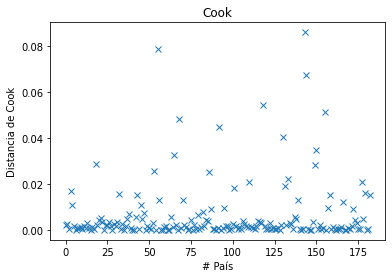

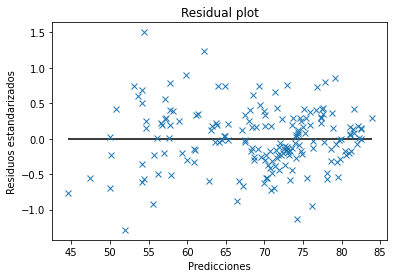

--------------------------------------------------------------------------------------------------------------------------------


In [12]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [13]:
# infant deaths

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [59.28955165]
	 -0.048089 	 Adult Mortality
	 +0.099762 	 Alcohol
	 +0.000738 	 percentage expenditure
	 -0.027538 	 Hepatitis B
	 +0.000021 	 Measles
	 +0.048464 	 BMI
	 -0.008876 	 under-five deaths
	 +0.009396 	 Polio
	 +0.012543 	 Total expenditure
	 +0.106661 	 Diphtheria
	 -0.172551 	 HIV/AIDS
	 -0.000060 	 GDP
	 +0.000000 	 Population
	 -0.096026 	 thinness  1-19 years
	 +0.146878 	 thinness 5-9 years
	 +6.820976 	 Income composition of resources
	 +0.328865 	 Schooling
	 -0.152637 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9329584813218302
	 R² con ajuste: 0.925600265857153

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -4.612777 	 Adult Mortality
	 +0.382088 	 Alcohol
	 +1.089259 	 percentage expenditure
	 -0.472821 	 Hepatitis B
	 +0.169349 	 Measles
	 +0.764749 	 BMI
	 -1.393430 	 under-five deaths
	 +0.149905 	 Polio
	 +0.023922 	 Total expenditure
	 +1.757

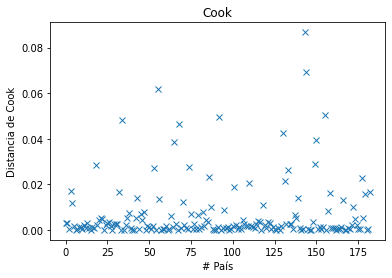

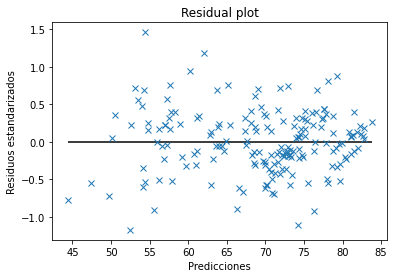

--------------------------------------------------------------------------------------------------------------------------------


In [14]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [15]:
# thinness 5-9 years

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [59.32224095]
	 -0.047978 	 Adult Mortality
	 +0.100881 	 Alcohol
	 +0.000736 	 percentage expenditure
	 -0.029086 	 Hepatitis B
	 +0.000021 	 Measles
	 +0.046464 	 BMI
	 -0.009102 	 under-five deaths
	 +0.009655 	 Polio
	 +0.006540 	 Total expenditure
	 +0.108006 	 Diphtheria
	 -0.173426 	 HIV/AIDS
	 -0.000062 	 GDP
	 +0.000000 	 Population
	 +0.046657 	 thinness  1-19 years
	 +6.853513 	 Income composition of resources
	 +0.333803 	 Schooling
	 -0.154423 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9328431210593147
	 R² con ajuste: 0.9259239274714864

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -4.602182 	 Adult Mortality
	 +0.386374 	 Alcohol
	 +1.086683 	 percentage expenditure
	 -0.499411 	 Hepatitis B
	 +0.171949 	 Measles
	 +0.733192 	 BMI
	 -1.428950 	 under-five deaths
	 +0.154040 	 Polio
	 +0.012473 	 Total expenditure
	 +1.779387 	 Diphtheria
	 -0.769225 	 H

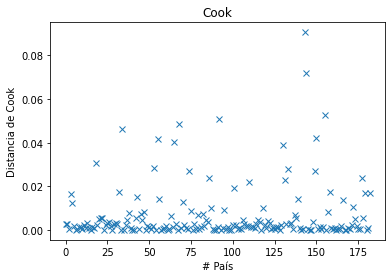

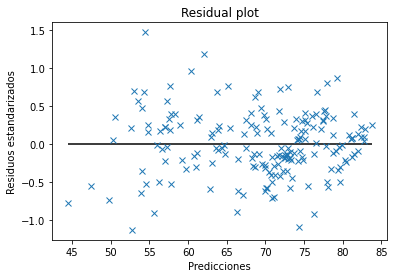

--------------------------------------------------------------------------------------------------------------------------------


In [16]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [17]:
# under-five deaths

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [59.08033597]
	 -0.047796 	 Adult Mortality
	 +0.086027 	 Alcohol
	 +0.000771 	 percentage expenditure
	 -0.031245 	 Hepatitis B
	 -0.000044 	 Measles
	 +0.040128 	 BMI
	 +0.010975 	 Polio
	 -0.018720 	 Total expenditure
	 +0.114823 	 Diphtheria
	 -0.176455 	 HIV/AIDS
	 -0.000072 	 GDP
	 +0.000000 	 Population
	 -0.006209 	 thinness  1-19 years
	 +7.167220 	 Income composition of resources
	 +0.364253 	 Schooling
	 -0.165052 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.930811235029899
	 R² con ajuste: 0.9241424384062749

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -4.584681 	 Adult Mortality
	 +0.329482 	 Alcohol
	 +1.138065 	 percentage expenditure
	 -0.536477 	 Hepatitis B
	 -0.354895 	 Measles
	 +0.633216 	 BMI
	 +0.175099 	 Polio
	 -0.035705 	 Total expenditure
	 +1.891693 	 Diphtheria
	 -0.782661 	 HIV/AIDS
	 -0.739532 	 GDP
	 +0.022561 	 Population
	 -0.025227 	 

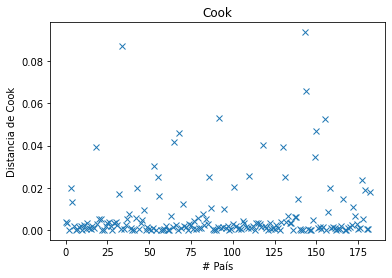

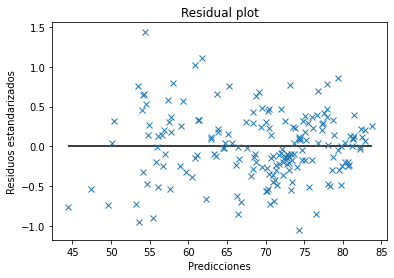

--------------------------------------------------------------------------------------------------------------------------------


In [18]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [19]:
# Polio

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [59.17986574]
	 -0.047944 	 Adult Mortality
	 +0.087263 	 Alcohol
	 +0.000775 	 percentage expenditure
	 -0.029810 	 Hepatitis B
	 -0.000044 	 Measles
	 +0.040381 	 BMI
	 -0.022910 	 Total expenditure
	 +0.123035 	 Diphtheria
	 -0.175057 	 HIV/AIDS
	 -0.000072 	 GDP
	 +0.000000 	 Population
	 -0.006043 	 thinness  1-19 years
	 +7.161944 	 Income composition of resources
	 +0.368193 	 Schooling
	 -0.161509 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9307780989545881
	 R² con ajuste: 0.9245605629325451

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -4.598916 	 Adult Mortality
	 +0.334218 	 Alcohol
	 +1.145212 	 percentage expenditure
	 -0.511841 	 Hepatitis B
	 -0.352427 	 Measles
	 +0.637206 	 BMI
	 -0.043696 	 Total expenditure
	 +2.026996 	 Diphtheria
	 -0.776460 	 HIV/AIDS
	 -0.748024 	 GDP
	 +0.021503 	 Population
	 -0.024549 	 thinness  1-19 years
	 +1.293397 	 Inco

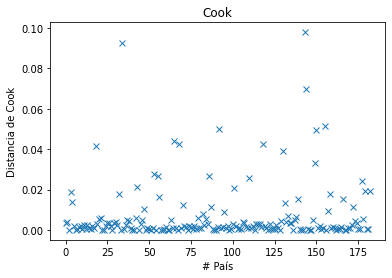

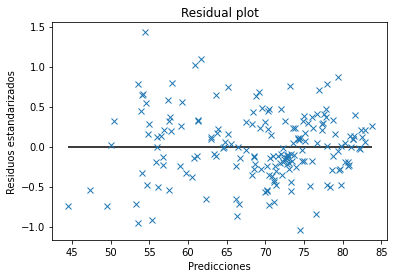

--------------------------------------------------------------------------------------------------------------------------------


In [20]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [21]:
# GDP

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [59.44090768]
	 -0.047405 	 Adult Mortality
	 +0.079942 	 Alcohol
	 +0.000371 	 percentage expenditure
	 -0.031200 	 Hepatitis B
	 -0.000044 	 Measles
	 +0.036150 	 BMI
	 -0.003461 	 Total expenditure
	 +0.122736 	 Diphtheria
	 -0.182197 	 HIV/AIDS
	 +0.000000 	 Population
	 -0.015258 	 thinness  1-19 years
	 +6.373839 	 Income composition of resources
	 +0.385857 	 Schooling
	 -0.169601 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9299341465487323
	 R² con ajuste: 0.9240953254277933

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -4.547189 	 Adult Mortality
	 +0.306178 	 Alcohol
	 +0.547900 	 percentage expenditure
	 -0.535699 	 Hepatitis B
	 -0.354844 	 Measles
	 +0.570441 	 BMI
	 -0.006601 	 Total expenditure
	 +2.022067 	 Diphtheria
	 -0.808128 	 HIV/AIDS
	 +0.045111 	 Population
	 -0.061989 	 thinness  1-19 years
	 +1.151070 	 Income composition of resources
	 +1.186

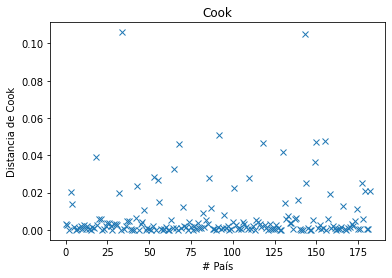

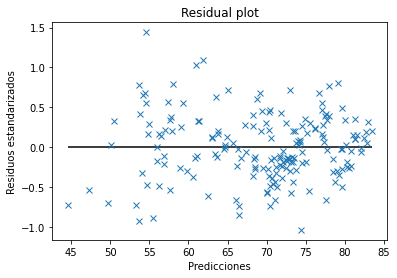

--------------------------------------------------------------------------------------------------------------------------------


In [22]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [23]:
# Schooling

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [60.10339417]
	 -0.048024 	 Adult Mortality
	 +0.126101 	 Alcohol
	 +0.000415 	 percentage expenditure
	 -0.024806 	 Hepatitis B
	 -0.000039 	 Measles
	 +0.049541 	 BMI
	 +0.036192 	 Total expenditure
	 +0.124024 	 Diphtheria
	 -0.166728 	 HIV/AIDS
	 +0.000000 	 Population
	 -0.000400 	 thinness  1-19 years
	 +10.198242 	 Income composition of resources
	 -0.194161 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.9268072108695186
	 R² con ajuste: 0.92117699632102

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -4.606580 	 Adult Mortality
	 +0.482967 	 Alcohol
	 +0.613220 	 percentage expenditure
	 -0.425919 	 Hepatitis B
	 -0.316327 	 Measles
	 +0.781749 	 BMI
	 +0.069030 	 Total expenditure
	 +2.043284 	 Diphtheria
	 -0.739516 	 HIV/AIDS
	 +0.018285 	 Population
	 -0.001624 	 thinness  1-19 years
	 +1.841730 	 Income composition of resources
	 -0.245991 	 Poisoning

VIF:
	 +

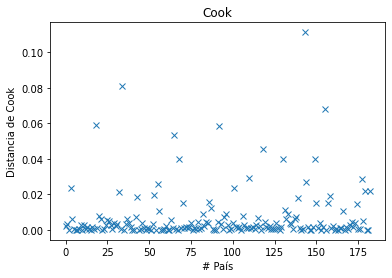

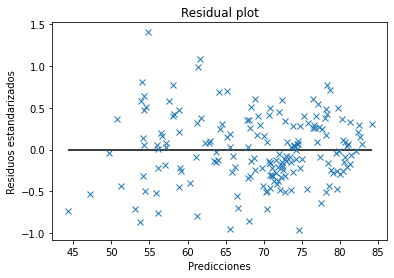

--------------------------------------------------------------------------------------------------------------------------------


In [24]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

In [25]:
# ADULT MORTALITY

Tenemos un modelo con todos los VIF < 5, con coeficiente dominante ADULT MORTALITY.

Pero esta variable no es accionable, por lo que decidimos no considerarla desde el principio.

# Backwards selection sin ADULT MORTALITY

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [43.50903615]
	 +0.051656 	 infant deaths
	 -0.006344 	 Alcohol
	 +0.000858 	 percentage expenditure
	 -0.045337 	 Hepatitis B
	 +0.000042 	 Measles
	 +0.105496 	 BMI
	 -0.043110 	 under-five deaths
	 +0.065693 	 Polio
	 +0.099860 	 Total expenditure
	 +0.107020 	 Diphtheria
	 -0.682864 	 HIV/AIDS
	 +0.000003 	 GDP
	 +0.000000 	 Population
	 +0.106398 	 thinness  1-19 years
	 -0.035448 	 thinness 5-9 years
	 +9.685562 	 Income composition of resources
	 +0.435109 	 Schooling
	 -0.502424 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8746281250911654
	 R² con ajuste: 0.8608677973572689

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 +5.975473 	 infant deaths
	 -0.024298 	 Alcohol
	 +1.266460 	 percentage expenditure
	 -0.778441 	 Hepatitis B
	 +0.342033 	 Measles
	 +1.664704 	 BMI
	 -6.768166 	 under-five deaths
	 +1.048104 	 Polio
	 +0.190463 	 Total expenditure
	 +1.763154

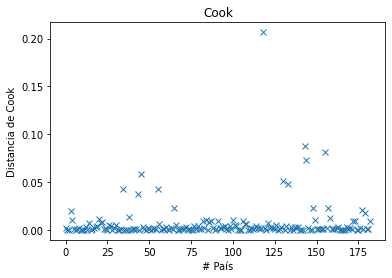

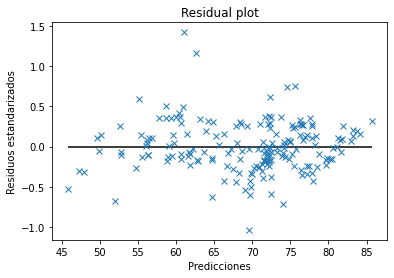

--------------------------------------------------------------------------------------------------------------------------------


In [26]:
analisis(datos_con_medianas_segregadas, ['infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [27]:
# infant deaths

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [42.7144859]
	 -0.031375 	 Alcohol
	 +0.000858 	 percentage expenditure
	 -0.050440 	 Hepatitis B
	 +0.000054 	 Measles
	 +0.105700 	 BMI
	 -0.008126 	 under-five deaths
	 +0.071158 	 Polio
	 +0.112428 	 Total expenditure
	 +0.112845 	 Diphtheria
	 -0.687610 	 HIV/AIDS
	 -0.000001 	 GDP
	 +0.000000 	 Population
	 +0.114443 	 thinness  1-19 years
	 -0.028534 	 thinness 5-9 years
	 +10.211050 	 Income composition of resources
	 +0.425538 	 Schooling
	 -0.523375 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.872977691301279
	 R² con ajuste: 0.8598905443444411

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -0.120167 	 Alcohol
	 +1.267827 	 percentage expenditure
	 -0.866049 	 Hepatitis B
	 +0.437397 	 Measles
	 +1.667915 	 BMI
	 -1.275814 	 under-five deaths
	 +1.135292 	 Polio
	 +0.214433 	 Total expenditure
	 +1.859106 	 Diphtheria
	 -3.049869 	 HIV/AIDS
	 -0.005301 	 GDP
	 

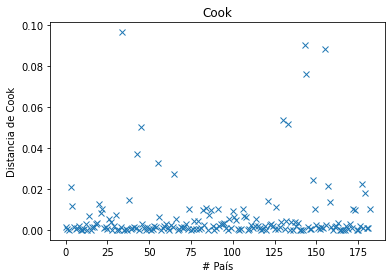

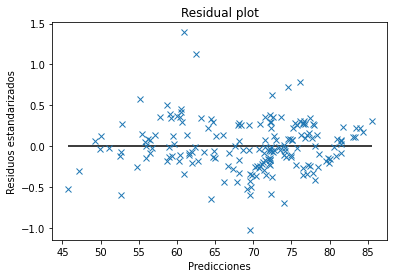

--------------------------------------------------------------------------------------------------------------------------------


In [28]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [29]:
# thinness 5-9 years

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [42.70070164]
	 -0.031652 	 Alcohol
	 +0.000859 	 percentage expenditure
	 -0.050148 	 Hepatitis B
	 +0.000054 	 Measles
	 +0.106115 	 BMI
	 -0.008082 	 under-five deaths
	 +0.071135 	 Polio
	 +0.113642 	 Total expenditure
	 +0.112585 	 Diphtheria
	 -0.687670 	 HIV/AIDS
	 -0.000000 	 GDP
	 +0.000000 	 Population
	 +0.086743 	 thinness  1-19 years
	 +10.206228 	 Income composition of resources
	 +0.424619 	 Schooling
	 -0.523193 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.872973325695065
	 R² con ajuste: 0.8607297908223002

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -0.121227 	 Alcohol
	 +1.268409 	 percentage expenditure
	 -0.861045 	 Hepatitis B
	 +0.437010 	 Measles
	 +1.674466 	 BMI
	 -1.268842 	 under-five deaths
	 +1.134927 	 Polio
	 +0.216749 	 Total expenditure
	 +1.854834 	 Diphtheria
	 -3.050135 	 HIV/AIDS
	 -0.002585 	 GDP
	 +0.767840 	 Population
	 +0.3524

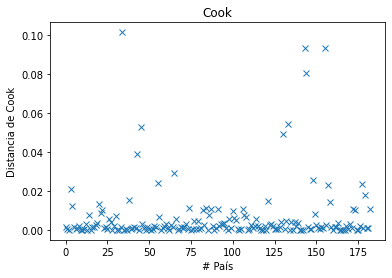

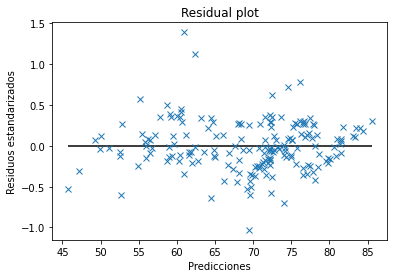

--------------------------------------------------------------------------------------------------------------------------------


In [30]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [31]:
# under-five deaths

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [42.54195766]
	 -0.044400 	 Alcohol
	 +0.000889 	 percentage expenditure
	 -0.051995 	 Hepatitis B
	 -0.000004 	 Measles
	 +0.100285 	 BMI
	 +0.072100 	 Polio
	 +0.090841 	 Total expenditure
	 +0.118625 	 Diphtheria
	 -0.688624 	 HIV/AIDS
	 -0.000009 	 GDP
	 -0.000000 	 Population
	 +0.039645 	 thinness  1-19 years
	 +10.473579 	 Income composition of resources
	 +0.451362 	 Schooling
	 -0.531389 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8713705773708109
	 R² con ajuste: 0.8598170364160933

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -0.170052 	 Alcohol
	 +1.313440 	 percentage expenditure
	 -0.892750 	 Hepatitis B
	 -0.031897 	 Measles
	 +1.582475 	 BMI
	 +1.150321 	 Polio
	 +0.173261 	 Total expenditure
	 +1.954345 	 Diphtheria
	 -3.054366 	 HIV/AIDS
	 -0.097822 	 GDP
	 -0.061687 	 Population
	 +0.161063 	 thinness  1-19 years
	 +1.891454 	 Income composition of r

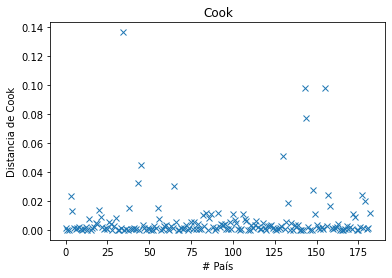

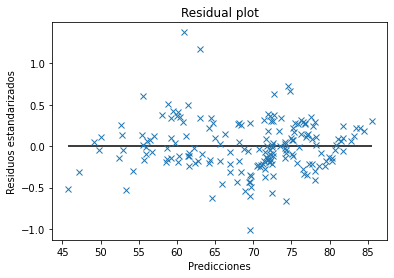

--------------------------------------------------------------------------------------------------------------------------------


In [32]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [33]:
# Diphtheria

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [42.61555738]
	 -0.044823 	 Alcohol
	 +0.000842 	 percentage expenditure
	 -0.036245 	 Hepatitis B
	 -0.000012 	 Measles
	 +0.101510 	 BMI
	 +0.170275 	 Polio
	 +0.136757 	 Total expenditure
	 -0.683935 	 HIV/AIDS
	 -0.000001 	 GDP
	 +0.000000 	 Population
	 +0.044871 	 thinness  1-19 years
	 +11.087106 	 Income composition of resources
	 +0.422321 	 Schooling
	 -0.593717 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8670951870521073
	 R² con ajuste: 0.8560197859731162

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -0.171671 	 Alcohol
	 +1.244222 	 percentage expenditure
	 -0.622324 	 Hepatitis B
	 -0.094889 	 Measles
	 +1.601798 	 BMI
	 +2.716664 	 Polio
	 +0.260836 	 Total expenditure
	 -3.033569 	 HIV/AIDS
	 -0.010930 	 GDP
	 +0.007101 	 Population
	 +0.182294 	 thinness  1-19 years
	 +2.002253 	 Income composition of resources
	 +1.298111 	 Schooling
	 -0.752208 	 Poi

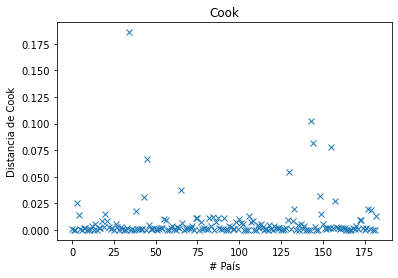

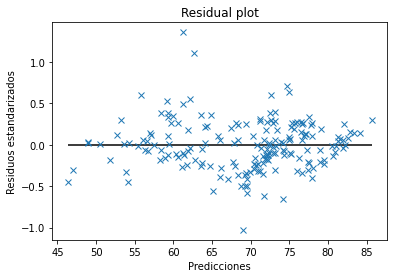

--------------------------------------------------------------------------------------------------------------------------------


In [34]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [35]:
# GDP

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [42.62193264]
	 -0.044913 	 Alcohol
	 +0.000836 	 percentage expenditure
	 -0.036273 	 Hepatitis B
	 -0.000012 	 Measles
	 +0.101435 	 BMI
	 +0.170278 	 Polio
	 +0.137026 	 Total expenditure
	 -0.683956 	 HIV/AIDS
	 +0.000000 	 Population
	 +0.044724 	 thinness  1-19 years
	 +11.074696 	 Income composition of resources
	 +0.422559 	 Schooling
	 -0.593764 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8670950050741428
	 R² con ajuste: 0.856871543926

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 -0.172015 	 Alcohol
	 +1.235369 	 percentage expenditure
	 -0.622809 	 Hepatitis B
	 -0.094972 	 Measles
	 +1.600618 	 BMI
	 +2.716706 	 Polio
	 +0.261350 	 Total expenditure
	 -3.033662 	 HIV/AIDS
	 +0.007446 	 Population
	 +0.181698 	 thinness  1-19 years
	 +2.000012 	 Income composition of resources
	 +1.298843 	 Schooling
	 -0.752268 	 Poisoning

VIF:
	 +2.023658 	 Alcohol
	 +1.

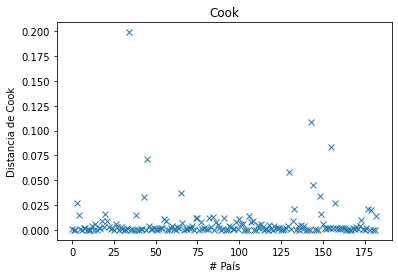

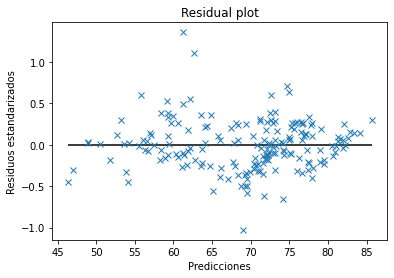

--------------------------------------------------------------------------------------------------------------------------------


In [36]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [37]:
# Schooling

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [43.04658766]
	 +0.002778 	 Alcohol
	 +0.000889 	 percentage expenditure
	 -0.032092 	 Hepatitis B
	 -0.000006 	 Measles
	 +0.116396 	 BMI
	 +0.176739 	 Polio
	 +0.182852 	 Total expenditure
	 -0.674391 	 HIV/AIDS
	 -0.000000 	 Population
	 +0.061041 	 thinness  1-19 years
	 +15.259045 	 Income composition of resources
	 -0.624325 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.863360763662577
	 R² con ajuste: 0.8537156410975824

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 +0.010639 	 Alcohol
	 +1.313667 	 percentage expenditure
	 -0.551019 	 Hepatitis B
	 -0.048109 	 Measles
	 +1.836706 	 BMI
	 +2.819787 	 Polio
	 +0.348754 	 Total expenditure
	 -2.991237 	 HIV/AIDS
	 -0.026298 	 Population
	 +0.247987 	 thinness  1-19 years
	 +2.755676 	 Income composition of resources
	 -0.790987 	 Poisoning

VIF:
	 +1.917209 	 Alcohol
	 +1.594449 	 percentage expenditure
	 +3.109151 	

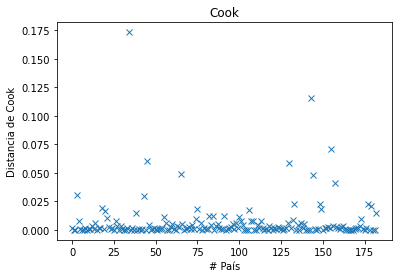

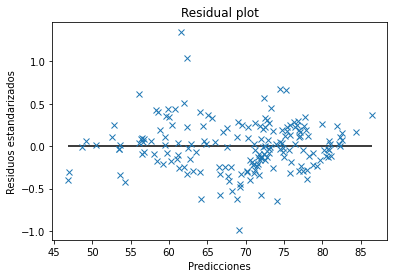

--------------------------------------------------------------------------------------------------------------------------------


In [38]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

Tenemos un modelo con todos los VIF < 5, con coeficiente dominante HIV/AIDS (y POLIO muy pegadito).

Con este análisis llegamos a un grupo de predictores donde por lo menos hay un elemento de cada uno de los grupos de correlación obtenidos en el EDA.

Pero:

POPULATION no es directamente accionable, porfa.

ALCOHOL es el coeficiente que menor aporta al modelo, además de ser confounding. ("Más se vive, más se bebe")

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [43.06635703]
	 +0.000890 	 percentage expenditure
	 -0.031811 	 Hepatitis B
	 -0.000007 	 Measles
	 +0.115869 	 BMI
	 +0.176603 	 Polio
	 +0.183929 	 Total expenditure
	 -0.674102 	 HIV/AIDS
	 +0.056722 	 thinness  1-19 years
	 +15.269893 	 Income composition of resources
	 -0.621498 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8633555703890466
	 R² con ajuste: 0.8554111268070145

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 +1.314518 	 percentage expenditure
	 -0.546195 	 Hepatitis B
	 -0.057356 	 Measles
	 +1.828376 	 BMI
	 +2.817613 	 Polio
	 +0.350807 	 Total expenditure
	 -2.989954 	 HIV/AIDS
	 +0.230442 	 thinness  1-19 years
	 +2.757635 	 Income composition of resources
	 -0.787406 	 Poisoning

VIF:
	 +1.551718 	 percentage expenditure
	 +3.017396 	 Hepatitis B
	 +1.215473 	 Measles
	 +3.101433 	 BMI
	 +3.895148 	 Polio
	 +1.265649 	 Total expenditure
	 +1.24686

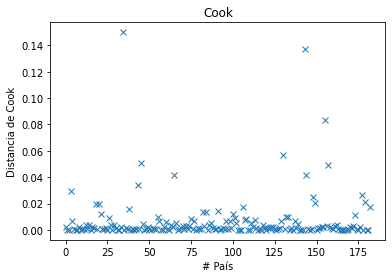

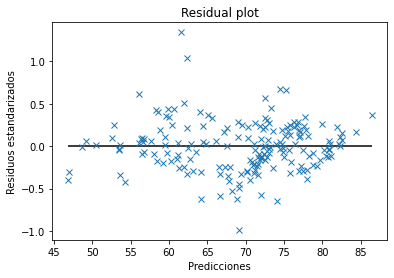

--------------------------------------------------------------------------------------------------------------------------------


In [39]:
analisis(datos_con_medianas_segregadas, ['percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

Sabemos que POLIO y HEPATITIS B están correlacionados. Optamos por sacar la segunda dado que tiene un menor coeficiente.

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [42.68469289]
	 +0.000933 	 percentage expenditure
	 +0.000000 	 Measles
	 +0.120976 	 BMI
	 +0.146949 	 Polio
	 +0.175442 	 Total expenditure
	 -0.667453 	 HIV/AIDS
	 +0.063826 	 thinness  1-19 years
	 +15.391537 	 Income composition of resources
	 -0.632649 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8621775580087897
	 R² con ajuste: 0.8550076043791892

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 +1.378249 	 percentage expenditure
	 +0.000591 	 Measles
	 +1.908972 	 BMI
	 +2.344508 	 Polio
	 +0.334621 	 Total expenditure
	 -2.960460 	 HIV/AIDS
	 +0.259304 	 thinness  1-19 years
	 +2.779603 	 Income composition of resources
	 -0.801533 	 Poisoning

VIF:
	 +1.510637 	 percentage expenditure
	 +1.181511 	 Measles
	 +3.035733 	 BMI
	 +1.631284 	 Polio
	 +1.262999 	 Total expenditure
	 +1.238064 	 HIV/AIDS
	 +2.186559 	 thinness  1-19 years
	 +2.720201 	 Income compositi

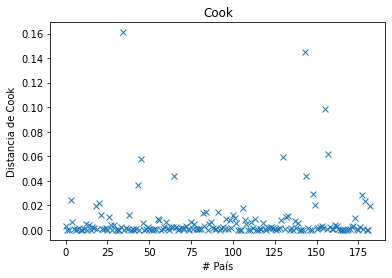

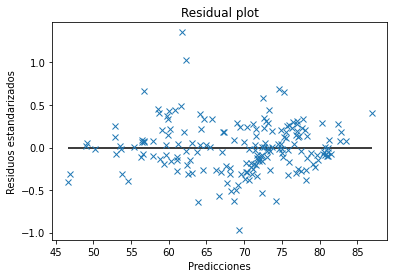

--------------------------------------------------------------------------------------------------------------------------------


In [40]:
analisis(datos_con_medianas_segregadas, ['percentage expenditure', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

En el nuevo modelo Measels se vuelve insignificante (por su coeficiente)

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [42.68517297]
	 +0.000933 	 percentage expenditure
	 +0.120968 	 BMI
	 +0.146942 	 Polio
	 +0.175438 	 Total expenditure
	 -0.667463 	 HIV/AIDS
	 +0.063855 	 thinness  1-19 years
	 +15.392320 	 Income composition of resources
	 -0.632629 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8621775544919075
	 R² con ajuste: 0.8558408903306158

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 +1.378226 	 percentage expenditure
	 +1.908837 	 BMI
	 +2.344397 	 Polio
	 +0.334612 	 Total expenditure
	 -2.960505 	 HIV/AIDS
	 +0.259419 	 thinness  1-19 years
	 +2.779744 	 Income composition of resources
	 -0.801508 	 Poisoning

VIF:
	 +1.508863 	 percentage expenditure
	 +2.973715 	 BMI
	 +1.589582 	 Polio
	 +1.262702 	 Total expenditure
	 +1.231283 	 HIV/AIDS
	 +2.141461 	 thinness  1-19 years
	 +2.652461 	 Income composition of resources
	 +1.150775 	 Poisoning

COOK:
	 +0.158368 	 Sierr

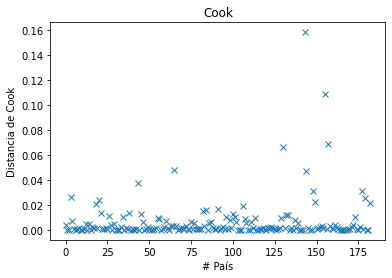

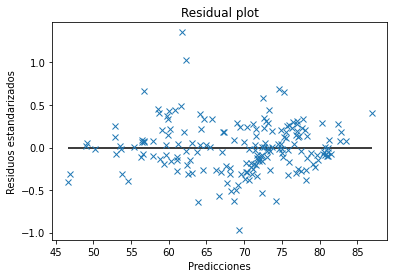

--------------------------------------------------------------------------------------------------------------------------------


In [41]:
analisis(datos_con_medianas_segregadas, ['percentage expenditure', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

Con este último modelo conseguimos un R² (ajustado) relativamente alto, con valores razonablemente bajos de VIF, utilizando pocas variables simples, es decir, cada regresor se basa en un único dato.

# Separar modelo según nivel de desarrollo

In [57]:
datos_desarrollados = datos_con_medianas_segregadas[datos_con_medianas_segregadas["Status"] == "Developed"]
datos_en_desarrollo = datos_con_medianas_segregadas[datos_con_medianas_segregadas["Status"] == "Developing"]

Países: 32

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [-148.27631778]
	 +0.000014 	 percentage expenditure
	 -0.099849 	 BMI
	 +0.025320 	 Polio
	 -0.102362 	 Total expenditure
	 +2048.000000 	 HIV/AIDS
	 -2.383427 	 thinness  1-19 years
	 +34.064578 	 Income composition of resources
	 +0.257954 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8101355486001132
	 R² con ajuste: 0.7440957394175438

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 +0.034150 	 percentage expenditure
	 -0.775451 	 BMI
	 +0.111502 	 Polio
	 -0.213494 	 Total expenditure
	 +0.000000 	 HIV/AIDS
	 -1.769872 	 thinness  1-19 years
	 +1.552903 	 Income composition of resources
	 +0.398412 	 Poisoning

VIF:
	 +2.542683 	 percentage expenditure
	 +1.455109 	 BMI
	 +1.277161 	 Polio
	 +1.853499 	 Total expenditure
	 +1.000000 	 HIV/AIDS
	 +2.382940 	 thinness  1-19 years
	 +2.986725 	 Income composition of resources
	 +1.211868 	 Poisoning

COOK:
	 +0.207141 	 A

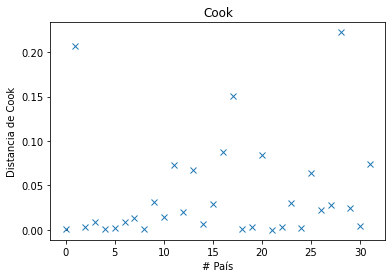

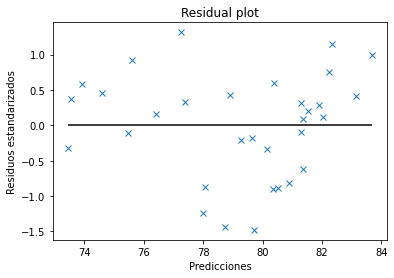

--------------------------------------------------------------------------------------------------------------------------------


In [59]:
analisis(datos_desarrollados, ['percentage expenditure', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

Países: 151

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [43.49836907]
	 +0.001484 	 percentage expenditure
	 +0.138626 	 BMI
	 +0.143273 	 Polio
	 +0.169147 	 Total expenditure
	 -0.650130 	 HIV/AIDS
	 +0.115095 	 thinness  1-19 years
	 +13.074504 	 Income composition of resources
	 -0.867641 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8326139346529307
	 R² con ajuste: 0.823183733788307

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 +0.937670 	 percentage expenditure
	 +2.155153 	 BMI
	 +2.360053 	 Polio
	 +0.282689 	 Total expenditure
	 -3.127742 	 HIV/AIDS
	 +0.469980 	 thinness  1-19 years
	 +2.123294 	 Income composition of resources
	 -1.039745 	 Poisoning

VIF:
	 +1.381846 	 percentage expenditure
	 +2.751927 	 BMI
	 +1.474534 	 Polio
	 +1.174328 	 Total expenditure
	 +1.233064 	 HIV/AIDS
	 +1.881743 	 thinness  1-19 years
	 +2.099591 	 Income composition of resources
	 +1.234126 	 Poisoning

COOK:
	 +0.191666 	 Sierra

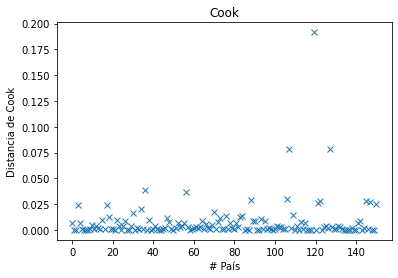

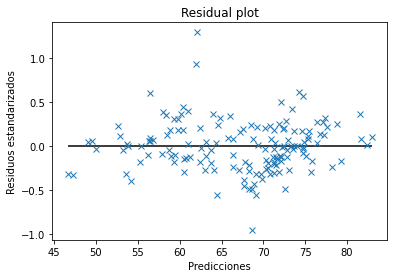

--------------------------------------------------------------------------------------------------------------------------------


In [58]:
analisis(datos_en_desarrollo, ['percentage expenditure', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

No aporta

# BMI insano
Teniendo en cuenta que BMI y thinness toman lugares contrapuestos y que se balancean, intentaremos considerar solo la distancia al BMI ideal.

In [69]:
if not ("BMI modulo" in datos_con_medianas_segregadas.columns):
    datos_con_medianas_segregadas.insert(0, "BMI modulo", 0)
datos_con_medianas_segregadas["BMI modulo"] = np.abs(datos_con_medianas_segregadas["BMI"]-22.5)

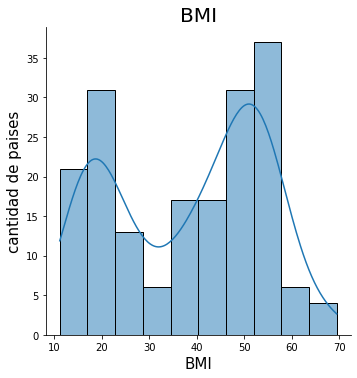

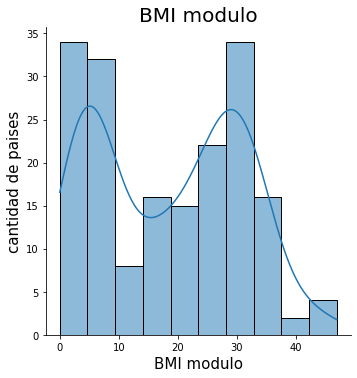

In [75]:
import seaborn as sns

feature = "BMI"
sns.displot(datos_con_medianas_segregadas[feature], bins = 10, kde = True)
plt.title(feature, fontsize = 20)
plt.ylabel("cantidad de paises", fontsize = 15)
plt.xlabel(feature, fontsize = 15)
plt.show()

feature = "BMI modulo"
sns.displot(datos_con_medianas_segregadas[feature], bins = 10, kde = True)
plt.title(feature, fontsize = 20)
plt.ylabel("cantidad de paises", fontsize = 15)
plt.xlabel(feature, fontsize = 15)
plt.show()

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [44.25822164]
	 +0.000892 	 percentage expenditure
	 +0.123304 	 BMI modulo
	 +0.154537 	 Polio
	 +0.164627 	 Total expenditure
	 -0.652663 	 HIV/AIDS
	 +16.295203 	 Income composition of resources
	 -0.678129 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8584703737965449
	 R² con ajuste: 0.8528091887484067

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 +1.316651 	 percentage expenditure
	 +1.516219 	 BMI modulo
	 +2.465564 	 Polio
	 +0.313993 	 Total expenditure
	 -2.894863 	 HIV/AIDS
	 +2.942798 	 Income composition of resources
	 -0.859154 	 Poisoning

VIF:
	 +1.482814 	 percentage expenditure
	 +1.959694 	 BMI modulo
	 +1.564723 	 Polio
	 +1.263457 	 Total expenditure
	 +1.283818 	 HIV/AIDS
	 +2.552406 	 Income composition of resources
	 +1.149460 	 Poisoning

COOK:
	 +0.177123 	 Sierra Leone
	 +0.120981 	 Swaziland


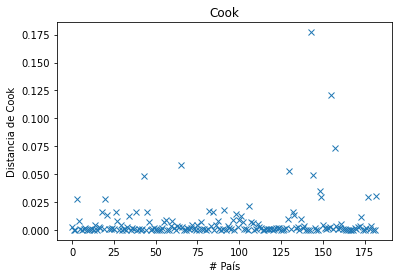

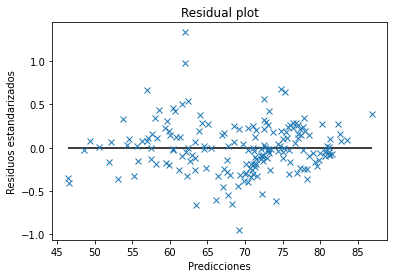

--------------------------------------------------------------------------------------------------------------------------------


In [81]:
analisis(datos_con_medianas_segregadas, ['percentage expenditure', 'BMI modulo', 'Polio', 'Total expenditure', 'HIV/AIDS', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

Su coeficiente asociado es positivo, lo que carece de sentido.

# Outliers
Los países que eran outliers, dejaron de serlo al corregir sus datos tras el EDA, o al eliminar el predictor problemático durante la selección del modelo.

Por ejemplo, India debido a "Adult Mortality"

# Llegamos a un modelo relativamente bueno
8 variables directamente accionables:
*    percentage expenditure
*    BMI
*    Polio
*    Total expenditure
*    HIV/AIDS
*    thinness  1-19 years
*    Income composition of resources
*    Poisoning

R² con ajuste: 0.855